# MLDL2 Homework 4

In [1]:
import torch
import torch.nn as nn
from torchvision import transforms, datasets
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from torch.utils.data import Dataset
from torchvision import datasets
import torch.nn.functional as F
from tqdm.auto import tqdm

# 1. Load the CIFAR-100 Datasets


In [2]:
BATCH_SIZE = 64
VAL_SPLIT_RATIO = 0.2  # You can modify it

cifar100_transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.507, 0.487, 0.441), (0.267, 0.256, 0.276))
    ])

cifar100_train_dataset = datasets.CIFAR100(root="./data/", train=True, download=True, transform=cifar100_transform)

num_train = len(cifar100_train_dataset)
indices = torch.randperm(num_train)

val_split = int(num_train * VAL_SPLIT_RATIO)
train_indices = indices[val_split:]
val_indices = indices[:val_split]

#Do not change below code
cifar100_val_dataset = torch.utils.data.Subset(cifar100_train_dataset, val_indices)
cifar100_train_dataset = torch.utils.data.Subset(cifar100_train_dataset, train_indices)

cifar100_train_loader = torch.utils.data.DataLoader(dataset=cifar100_train_dataset, batch_size=BATCH_SIZE, shuffle=True)
cifar100_val_loader = torch.utils.data.DataLoader(dataset=cifar100_val_dataset, batch_size=BATCH_SIZE, shuffle=True)

Files already downloaded and verified


In [3]:
# Number of samples in the dataset

print("cifar100 train dataset size : ", len(cifar100_train_dataset))
print("cifar100 validation dataset size : ", len(cifar100_val_dataset))

cifar100 train dataset size :  40000
cifar100 validation dataset size :  10000


## CIFAR-100 Visualization

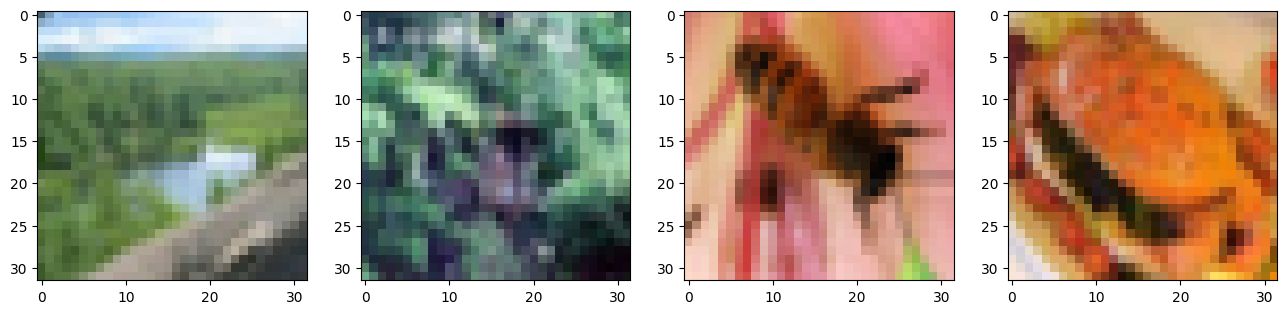

tensor([33, 37,  6, 26])


In [4]:
# Plot the training images and labels

cifar100_denormalize = transforms.Normalize(mean=[-0.507/0.267, -0.487/0.256, -0.441/0.276], std=[1/0.267, 1/0.256, 1/0.276])
to_pil_image = transforms.functional.to_pil_image

images, labels = next(iter(cifar100_train_loader))

fig, ax = plt.subplots(1, 4, figsize=(16, 4))
ax[0].imshow(to_pil_image(cifar100_denormalize(images[0])))
ax[1].imshow(to_pil_image(cifar100_denormalize(images[1])))
ax[2].imshow(to_pil_image(cifar100_denormalize(images[2])))
ax[3].imshow(to_pil_image(cifar100_denormalize(images[3])))
plt.show()

print(labels[:4])

# 2. Load Pretrained Model

Information of this pretrained model is here: https://huggingface.co/edadaltocg/resnet50_cifar100

In [5]:
!pip install detectors

In [6]:
# Do not modify the code
import detectors
import timm

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

teacher = timm.create_model("resnet50_cifar100", pretrained=True)
teacher.to(device)
teacher.eval()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (act1): ReLU(inplace=True)
  (maxpool): Identity()
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (act1): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (drop_block): Identity()
      (act2): ReLU(inplace=True)
      (aa): Identity()
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (act3): ReLU(inplace=True)
      (downsample): Sequential(
    

# 3. Define the Student Model Architecture

Here we define the model. Below is very simple model with CNN. You can customize your own model and note that you are not limited to use any methods. **But you are not allowed to use pretrained weight**

In [7]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class StudentModel(nn.Module):
    def __init__(self, num_classes=100):
        super(StudentModel, self).__init__()
        # Initial convolutional block
        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        
        # Residual blocks (simplified version of ResNet logic)
        self.layer1 = self._make_layer(64, 128, stride=2)
        self.layer2 = self._make_layer(128, 256, stride=2)
        self.layer3 = self._make_layer(256, 512, stride=2)
        
        # Global average pooling and fully connected layer
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512, num_classes)

    def _make_layer(self, in_channels, out_channels, stride):
        layers = []
        layers.append(nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False))
        layers.append(nn.BatchNorm2d(out_channels))
        layers.append(nn.ReLU(inplace=True))
        layers.append(nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False))
        layers.append(nn.BatchNorm2d(out_channels))
        layers.append(nn.ReLU(inplace=True))
        return nn.Sequential(*layers)
    
    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = F.relu(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)

        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)
        return x


In [8]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

student_model = StudentModel().to(device)

sample_input = torch.randn(4, 3, 32, 32).to(device)  
output = student_model(sample_input)  
print(output.shape)

Using device: cuda
torch.Size([4, 100])


# 4. Implement the Distillation Process

Here, you will implement distillation using a pretrained teacher model.

**The code below is just a sample training code, and does not implement the distillation method.**

Please make sure to implement the distillation method according to your own understanding.

You can change loss function, optimizer, number of epoch.

In [36]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from tqdm import tqdm
import os

# Load the teacher model (pre-trained ResNet-50)
teacher_model = models.resnet50(pretrained=True)  # Teacher model with pre-trained weights
teacher_model.fc = nn.Linear(2048, 100) 
teacher_model.eval() 

# Define student models 
student_model_1 = StudentModel(num_classes=100)
student_model_2 = StudentModel(num_classes=100)

# Hyperparameters
learning_rate = 0.001
num_epochs = 75
temperature = 5.0
alpha = 0.7  
batch_size = 64
checkpoint_dir = './checkpoints2'
os.makedirs(checkpoint_dir, exist_ok=True)

# CIFAR-100 Dataset
transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomCrop(32, padding=4),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
])

train_dataset = datasets.CIFAR100(root='./data', train=True, transform=transform, download=True)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

# Loss and optimizer
criterion_ce = nn.CrossEntropyLoss()  # Cross-entropy loss for ground truth
criterion_kl = nn.KLDivLoss(reduction='batchmean')  # KL divergence for logits
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

student_model_1 = student_model_1.to(device)
student_model_2 = student_model_2.to(device)
teacher_model = teacher_model.to(device)

optimizer_1 = optim.Adam(student_model_1.parameters(), lr=learning_rate)
optimizer_2 = optim.Adam(student_model_2.parameters(), lr=learning_rate)

# Training loop
for epoch in range(num_epochs):
    student_model_1.train()
    student_model_2.train()
    total_loss_1 = 0
    total_loss_2 = 0
    correct = 0
    total = 0

    with tqdm(total=len(train_loader), desc=f"Epoch {epoch + 1}/{num_epochs}") as pbar:
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)

            with torch.no_grad():
                teacher_logits = teacher_model(images) / temperature

            student_logits_1 = student_model_1(images)
            student_logits_2 = student_model_2(images)

            # Compute losses for both student models
            loss_ce_1 = criterion_ce(student_logits_1, labels)
            loss_kl_1 = criterion_kl(
                nn.functional.log_softmax(student_logits_1 / temperature, dim=1),
                nn.functional.softmax(teacher_logits, dim=1)
            )
            loss_1 = alpha * loss_kl_1 * (temperature ** 2) + (1 - alpha) * loss_ce_1

            loss_ce_2 = criterion_ce(student_logits_2, labels)
            loss_kl_2 = criterion_kl(
                nn.functional.log_softmax(student_logits_2 / temperature, dim=1),
                nn.functional.softmax(teacher_logits, dim=1)
            )
            loss_2 = alpha * loss_kl_2 * (temperature ** 2) + (1 - alpha) * loss_ce_2

            # Backward pass and optimization for both students
            optimizer_1.zero_grad()
            loss_1.backward()
            optimizer_1.step()

            optimizer_2.zero_grad()
            loss_2.backward()
            optimizer_2.step()

            total_loss_1 += loss_1.item()
            total_loss_2 += loss_2.item()

            # Ensemble predictions for accuracy
            ensemble_logits = (student_logits_1 + student_logits_2) / 2
            _, predicted = torch.max(ensemble_logits, 1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)

            pbar.update(1)
            pbar.set_postfix(loss_1=f"{loss_1.item():.4f}", loss_2=f"{loss_2.item():.4f}")

    accuracy = 100 * correct / total
    print(f"Epoch [{epoch + 1}/{num_epochs}], Loss 1: {total_loss_1 / len(train_loader):.4f}, Loss 2: {total_loss_2 / len(train_loader):.4f}, Training Accuracy: {accuracy:.2f}%")

    # Save student models for each epoch
    torch.save(student_model_1.state_dict(), os.path.join(checkpoint_dir, f'student_model_1_epoch_{epoch + 1}.pth'))
    torch.save(student_model_2.state_dict(), os.path.join(checkpoint_dir, f'student_model_2_epoch_{epoch + 1}.pth'))

# Save the final trained student models
torch.save(student_model_1.state_dict(), os.path.join(checkpoint_dir, 'student_model_1_final.pth'))
torch.save(student_model_2.state_dict(), os.path.join(checkpoint_dir, 'student_model_2_final.pth'))


Files already downloaded and verified


Epoch 1/75: 100%|██████████| 782/782 [00:54<00:00, 14.39it/s, loss_1=1.2460, loss_2=1.2447]


Epoch [1/75], Loss 1: 1.3446, Loss 2: 1.3469, Training Accuracy: 10.41%


Epoch 2/75: 100%|██████████| 782/782 [00:52<00:00, 14.88it/s, loss_1=1.1145, loss_2=1.1163]


Epoch [2/75], Loss 1: 1.2042, Loss 2: 1.2075, Training Accuracy: 24.29%


Epoch 3/75: 100%|██████████| 782/782 [00:52<00:00, 14.87it/s, loss_1=1.3400, loss_2=1.3500]


Epoch [3/75], Loss 1: 1.0982, Loss 2: 1.0995, Training Accuracy: 35.02%


Epoch 4/75: 100%|██████████| 782/782 [00:52<00:00, 14.92it/s, loss_1=1.0417, loss_2=1.0330]


Epoch [4/75], Loss 1: 1.0216, Loss 2: 1.0198, Training Accuracy: 42.85%


Epoch 5/75: 100%|██████████| 782/782 [00:52<00:00, 14.91it/s, loss_1=0.8847, loss_2=0.8491]


Epoch [5/75], Loss 1: 0.9636, Loss 2: 0.9600, Training Accuracy: 48.59%


Epoch 6/75: 100%|██████████| 782/782 [00:52<00:00, 14.92it/s, loss_1=0.8583, loss_2=0.8641]


Epoch [6/75], Loss 1: 0.9142, Loss 2: 0.9122, Training Accuracy: 53.36%


Epoch 7/75: 100%|██████████| 782/782 [00:52<00:00, 14.90it/s, loss_1=0.8794, loss_2=0.8731]


Epoch [7/75], Loss 1: 0.8738, Loss 2: 0.8701, Training Accuracy: 57.44%


Epoch 8/75: 100%|██████████| 782/782 [00:52<00:00, 14.92it/s, loss_1=0.8793, loss_2=0.9171]


Epoch [8/75], Loss 1: 0.8427, Loss 2: 0.8391, Training Accuracy: 60.33%


Epoch 9/75: 100%|██████████| 782/782 [00:52<00:00, 14.93it/s, loss_1=0.6564, loss_2=0.6768]


Epoch [9/75], Loss 1: 0.8135, Loss 2: 0.8108, Training Accuracy: 63.20%


Epoch 10/75: 100%|██████████| 782/782 [00:52<00:00, 14.89it/s, loss_1=0.9377, loss_2=0.9153]


Epoch [10/75], Loss 1: 0.7886, Loss 2: 0.7857, Training Accuracy: 65.78%


Epoch 11/75: 100%|██████████| 782/782 [00:52<00:00, 14.91it/s, loss_1=0.8664, loss_2=0.8842]


Epoch [11/75], Loss 1: 0.7679, Loss 2: 0.7655, Training Accuracy: 67.64%


Epoch 12/75: 100%|██████████| 782/782 [00:52<00:00, 14.87it/s, loss_1=0.7249, loss_2=0.6734]


Epoch [12/75], Loss 1: 0.7491, Loss 2: 0.7465, Training Accuracy: 69.42%


Epoch 13/75: 100%|██████████| 782/782 [00:52<00:00, 14.90it/s, loss_1=0.7955, loss_2=0.7342]


Epoch [13/75], Loss 1: 0.7304, Loss 2: 0.7274, Training Accuracy: 71.49%


Epoch 14/75: 100%|██████████| 782/782 [00:52<00:00, 14.92it/s, loss_1=0.9151, loss_2=0.8522]


Epoch [14/75], Loss 1: 0.7172, Loss 2: 0.7144, Training Accuracy: 72.87%


Epoch 15/75: 100%|██████████| 782/782 [00:52<00:00, 14.91it/s, loss_1=0.7063, loss_2=0.6892]


Epoch [15/75], Loss 1: 0.7000, Loss 2: 0.6986, Training Accuracy: 74.54%


Epoch 16/75: 100%|██████████| 782/782 [00:52<00:00, 14.91it/s, loss_1=0.9348, loss_2=0.9021]


Epoch [16/75], Loss 1: 0.6855, Loss 2: 0.6840, Training Accuracy: 76.31%


Epoch 17/75: 100%|██████████| 782/782 [00:52<00:00, 14.90it/s, loss_1=0.6215, loss_2=0.5937]


Epoch [17/75], Loss 1: 0.6732, Loss 2: 0.6715, Training Accuracy: 77.47%


Epoch 18/75: 100%|██████████| 782/782 [00:52<00:00, 14.93it/s, loss_1=0.5143, loss_2=0.5322]


Epoch [18/75], Loss 1: 0.6628, Loss 2: 0.6614, Training Accuracy: 78.53%


Epoch 19/75: 100%|██████████| 782/782 [00:52<00:00, 14.87it/s, loss_1=0.7722, loss_2=0.7204]


Epoch [19/75], Loss 1: 0.6507, Loss 2: 0.6502, Training Accuracy: 79.69%


Epoch 20/75: 100%|██████████| 782/782 [00:52<00:00, 14.90it/s, loss_1=0.7891, loss_2=0.7464]


Epoch [20/75], Loss 1: 0.6423, Loss 2: 0.6411, Training Accuracy: 80.75%


Epoch 21/75: 100%|██████████| 782/782 [00:52<00:00, 14.88it/s, loss_1=0.6508, loss_2=0.6070]


Epoch [21/75], Loss 1: 0.6308, Loss 2: 0.6296, Training Accuracy: 81.94%


Epoch 22/75: 100%|██████████| 782/782 [00:52<00:00, 14.89it/s, loss_1=0.7698, loss_2=0.7296]


Epoch [22/75], Loss 1: 0.6226, Loss 2: 0.6215, Training Accuracy: 82.82%


Epoch 23/75: 100%|██████████| 782/782 [00:52<00:00, 14.93it/s, loss_1=0.6502, loss_2=0.6116]


Epoch [23/75], Loss 1: 0.6145, Loss 2: 0.6141, Training Accuracy: 83.63%


Epoch 24/75: 100%|██████████| 782/782 [00:52<00:00, 14.92it/s, loss_1=0.6581, loss_2=0.6468]


Epoch [24/75], Loss 1: 0.6054, Loss 2: 0.6042, Training Accuracy: 84.68%


Epoch 25/75: 100%|██████████| 782/782 [00:52<00:00, 14.89it/s, loss_1=0.6626, loss_2=0.6977]


Epoch [25/75], Loss 1: 0.5978, Loss 2: 0.5961, Training Accuracy: 85.34%


Epoch 26/75: 100%|██████████| 782/782 [00:52<00:00, 14.84it/s, loss_1=0.8498, loss_2=0.7310]


Epoch [26/75], Loss 1: 0.5910, Loss 2: 0.5900, Training Accuracy: 86.34%


Epoch 27/75: 100%|██████████| 782/782 [00:52<00:00, 14.92it/s, loss_1=0.6492, loss_2=0.5815]


Epoch [27/75], Loss 1: 0.5834, Loss 2: 0.5819, Training Accuracy: 86.86%


Epoch 28/75: 100%|██████████| 782/782 [00:52<00:00, 14.90it/s, loss_1=0.5724, loss_2=0.5423]


Epoch [28/75], Loss 1: 0.5771, Loss 2: 0.5755, Training Accuracy: 87.56%


Epoch 29/75: 100%|██████████| 782/782 [00:52<00:00, 14.92it/s, loss_1=0.5531, loss_2=0.5518]


Epoch [29/75], Loss 1: 0.5706, Loss 2: 0.5690, Training Accuracy: 88.21%


Epoch 30/75: 100%|██████████| 782/782 [00:52<00:00, 14.89it/s, loss_1=0.7614, loss_2=0.7553]


Epoch [30/75], Loss 1: 0.5639, Loss 2: 0.5631, Training Accuracy: 88.88%


Epoch 31/75: 100%|██████████| 782/782 [00:54<00:00, 14.27it/s, loss_1=0.6210, loss_2=0.6304]


Epoch [31/75], Loss 1: 0.5601, Loss 2: 0.5578, Training Accuracy: 89.19%


Epoch 32/75: 100%|██████████| 782/782 [00:55<00:00, 14.18it/s, loss_1=0.6719, loss_2=0.6498]


Epoch [32/75], Loss 1: 0.5530, Loss 2: 0.5526, Training Accuracy: 89.94%


Epoch 33/75: 100%|██████████| 782/782 [00:52<00:00, 14.79it/s, loss_1=0.6637, loss_2=0.7452]


Epoch [33/75], Loss 1: 0.5469, Loss 2: 0.5462, Training Accuracy: 90.50%


Epoch 34/75: 100%|██████████| 782/782 [00:52<00:00, 14.76it/s, loss_1=0.6144, loss_2=0.5559]


Epoch [34/75], Loss 1: 0.5422, Loss 2: 0.5403, Training Accuracy: 90.96%


Epoch 35/75: 100%|██████████| 782/782 [00:52<00:00, 14.78it/s, loss_1=0.6613, loss_2=0.6712]


Epoch [35/75], Loss 1: 0.5372, Loss 2: 0.5354, Training Accuracy: 91.63%


Epoch 36/75: 100%|██████████| 782/782 [00:52<00:00, 14.77it/s, loss_1=0.5590, loss_2=0.5826]


Epoch [36/75], Loss 1: 0.5325, Loss 2: 0.5310, Training Accuracy: 92.08%


Epoch 37/75: 100%|██████████| 782/782 [00:52<00:00, 14.76it/s, loss_1=0.7140, loss_2=0.7108]


Epoch [37/75], Loss 1: 0.5282, Loss 2: 0.5261, Training Accuracy: 92.35%


Epoch 38/75: 100%|██████████| 782/782 [00:52<00:00, 14.77it/s, loss_1=0.6304, loss_2=0.6959]


Epoch [38/75], Loss 1: 0.5221, Loss 2: 0.5220, Training Accuracy: 92.86%


Epoch 39/75: 100%|██████████| 782/782 [00:52<00:00, 14.80it/s, loss_1=0.5477, loss_2=0.5443]


Epoch [39/75], Loss 1: 0.5189, Loss 2: 0.5165, Training Accuracy: 93.14%


Epoch 40/75: 100%|██████████| 782/782 [00:53<00:00, 14.75it/s, loss_1=0.5867, loss_2=0.6383]


Epoch [40/75], Loss 1: 0.5146, Loss 2: 0.5132, Training Accuracy: 93.49%


Epoch 41/75: 100%|██████████| 782/782 [00:52<00:00, 14.78it/s, loss_1=0.5214, loss_2=0.6411]


Epoch [41/75], Loss 1: 0.5101, Loss 2: 0.5094, Training Accuracy: 93.93%


Epoch 42/75: 100%|██████████| 782/782 [00:52<00:00, 14.80it/s, loss_1=0.5557, loss_2=0.5459]


Epoch [42/75], Loss 1: 0.5073, Loss 2: 0.5059, Training Accuracy: 94.17%


Epoch 43/75: 100%|██████████| 782/782 [00:53<00:00, 14.71it/s, loss_1=0.6331, loss_2=0.6340]


Epoch [43/75], Loss 1: 0.5044, Loss 2: 0.5019, Training Accuracy: 94.40%


Epoch 44/75: 100%|██████████| 782/782 [00:52<00:00, 14.88it/s, loss_1=0.6851, loss_2=0.6045]


Epoch [44/75], Loss 1: 0.4991, Loss 2: 0.4987, Training Accuracy: 94.63%


Epoch 45/75: 100%|██████████| 782/782 [00:52<00:00, 14.90it/s, loss_1=0.6346, loss_2=0.5138]


Epoch [45/75], Loss 1: 0.4965, Loss 2: 0.4945, Training Accuracy: 95.07%


Epoch 46/75: 100%|██████████| 782/782 [00:52<00:00, 14.94it/s, loss_1=0.5086, loss_2=0.4648]


Epoch [46/75], Loss 1: 0.4944, Loss 2: 0.4931, Training Accuracy: 95.11%


Epoch 47/75: 100%|██████████| 782/782 [00:52<00:00, 14.93it/s, loss_1=0.5526, loss_2=0.5643]


Epoch [47/75], Loss 1: 0.4890, Loss 2: 0.4884, Training Accuracy: 95.57%


Epoch 48/75: 100%|██████████| 782/782 [00:52<00:00, 14.89it/s, loss_1=0.5488, loss_2=0.5238]


Epoch [48/75], Loss 1: 0.4878, Loss 2: 0.4862, Training Accuracy: 95.69%


Epoch 49/75: 100%|██████████| 782/782 [00:52<00:00, 14.85it/s, loss_1=0.5778, loss_2=0.5654]


Epoch [49/75], Loss 1: 0.4844, Loss 2: 0.4831, Training Accuracy: 95.85%


Epoch 50/75: 100%|██████████| 782/782 [00:52<00:00, 14.88it/s, loss_1=0.6032, loss_2=0.5425]


Epoch [50/75], Loss 1: 0.4815, Loss 2: 0.4802, Training Accuracy: 96.13%


Epoch 51/75: 100%|██████████| 782/782 [00:52<00:00, 14.88it/s, loss_1=0.5700, loss_2=0.6504]


Epoch [51/75], Loss 1: 0.4783, Loss 2: 0.4777, Training Accuracy: 96.19%


Epoch 52/75: 100%|██████████| 782/782 [00:52<00:00, 14.86it/s, loss_1=0.5241, loss_2=0.4954]


Epoch [52/75], Loss 1: 0.4760, Loss 2: 0.4745, Training Accuracy: 96.42%


Epoch 53/75: 100%|██████████| 782/782 [00:52<00:00, 14.85it/s, loss_1=0.4902, loss_2=0.5181]


Epoch [53/75], Loss 1: 0.4728, Loss 2: 0.4725, Training Accuracy: 96.55%


Epoch 54/75: 100%|██████████| 782/782 [00:52<00:00, 14.87it/s, loss_1=0.5155, loss_2=0.5831]


Epoch [54/75], Loss 1: 0.4701, Loss 2: 0.4692, Training Accuracy: 96.70%


Epoch 55/75: 100%|██████████| 782/782 [00:52<00:00, 14.91it/s, loss_1=0.4996, loss_2=0.4479]


Epoch [55/75], Loss 1: 0.4671, Loss 2: 0.4667, Training Accuracy: 96.96%


Epoch 56/75: 100%|██████████| 782/782 [00:52<00:00, 14.87it/s, loss_1=0.5296, loss_2=0.5680]


Epoch [56/75], Loss 1: 0.4657, Loss 2: 0.4642, Training Accuracy: 97.07%


Epoch 57/75: 100%|██████████| 782/782 [00:52<00:00, 14.89it/s, loss_1=0.5023, loss_2=0.4509]


Epoch [57/75], Loss 1: 0.4630, Loss 2: 0.4624, Training Accuracy: 97.11%


Epoch 58/75: 100%|██████████| 782/782 [00:52<00:00, 14.90it/s, loss_1=0.5024, loss_2=0.5078]


Epoch [58/75], Loss 1: 0.4622, Loss 2: 0.4607, Training Accuracy: 97.19%


Epoch 59/75: 100%|██████████| 782/782 [00:52<00:00, 14.86it/s, loss_1=0.5587, loss_2=0.4514]


Epoch [59/75], Loss 1: 0.4602, Loss 2: 0.4585, Training Accuracy: 97.35%


Epoch 60/75: 100%|██████████| 782/782 [00:52<00:00, 14.84it/s, loss_1=0.4834, loss_2=0.5106]


Epoch [60/75], Loss 1: 0.4575, Loss 2: 0.4562, Training Accuracy: 97.51%


Epoch 61/75: 100%|██████████| 782/782 [00:52<00:00, 14.88it/s, loss_1=0.5597, loss_2=0.5254]


Epoch [61/75], Loss 1: 0.4556, Loss 2: 0.4536, Training Accuracy: 97.63%


Epoch 62/75: 100%|██████████| 782/782 [00:52<00:00, 14.86it/s, loss_1=0.6330, loss_2=0.5830]


Epoch [62/75], Loss 1: 0.4545, Loss 2: 0.4527, Training Accuracy: 97.69%


Epoch 63/75: 100%|██████████| 782/782 [00:52<00:00, 14.86it/s, loss_1=0.4971, loss_2=0.4997]


Epoch [63/75], Loss 1: 0.4519, Loss 2: 0.4509, Training Accuracy: 97.81%


Epoch 64/75: 100%|██████████| 782/782 [00:52<00:00, 14.87it/s, loss_1=0.4863, loss_2=0.4823]


Epoch [64/75], Loss 1: 0.4501, Loss 2: 0.4490, Training Accuracy: 97.79%


Epoch 65/75: 100%|██████████| 782/782 [00:53<00:00, 14.71it/s, loss_1=0.5148, loss_2=0.4940]


Epoch [65/75], Loss 1: 0.4492, Loss 2: 0.4467, Training Accuracy: 97.87%


Epoch 66/75: 100%|██████████| 782/782 [00:52<00:00, 14.84it/s, loss_1=0.5779, loss_2=0.5166]


Epoch [66/75], Loss 1: 0.4467, Loss 2: 0.4455, Training Accuracy: 98.01%


Epoch 67/75: 100%|██████████| 782/782 [00:52<00:00, 14.90it/s, loss_1=0.4487, loss_2=0.4988]


Epoch [67/75], Loss 1: 0.4444, Loss 2: 0.4442, Training Accuracy: 98.02%


Epoch 68/75: 100%|██████████| 782/782 [00:52<00:00, 14.84it/s, loss_1=0.5353, loss_2=0.4896]


Epoch [68/75], Loss 1: 0.4441, Loss 2: 0.4429, Training Accuracy: 98.16%


Epoch 69/75: 100%|██████████| 782/782 [00:52<00:00, 14.76it/s, loss_1=0.4695, loss_2=0.5190]


Epoch [69/75], Loss 1: 0.4406, Loss 2: 0.4405, Training Accuracy: 98.32%


Epoch 70/75: 100%|██████████| 782/782 [00:53<00:00, 14.55it/s, loss_1=0.4721, loss_2=0.4404]


Epoch [70/75], Loss 1: 0.4396, Loss 2: 0.4386, Training Accuracy: 98.26%


Epoch 71/75: 100%|██████████| 782/782 [00:53<00:00, 14.64it/s, loss_1=0.5040, loss_2=0.6368]


Epoch [71/75], Loss 1: 0.4388, Loss 2: 0.4373, Training Accuracy: 98.31%


Epoch 72/75: 100%|██████████| 782/782 [00:53<00:00, 14.64it/s, loss_1=0.5315, loss_2=0.5261]


Epoch [72/75], Loss 1: 0.4360, Loss 2: 0.4355, Training Accuracy: 98.49%


Epoch 73/75: 100%|██████████| 782/782 [00:53<00:00, 14.62it/s, loss_1=0.4778, loss_2=0.4479]


Epoch [73/75], Loss 1: 0.4354, Loss 2: 0.4336, Training Accuracy: 98.53%


Epoch 74/75: 100%|██████████| 782/782 [00:53<00:00, 14.65it/s, loss_1=0.4770, loss_2=0.4680]


Epoch [74/75], Loss 1: 0.4349, Loss 2: 0.4331, Training Accuracy: 98.55%


Epoch 75/75: 100%|██████████| 782/782 [00:54<00:00, 14.46it/s, loss_1=0.4393, loss_2=0.5461]


Epoch [75/75], Loss 1: 0.4326, Loss 2: 0.4310, Training Accuracy: 98.56%


# 5. Evaluate the network on the validation data

In [9]:
import os
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

transform_val = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

val_dataset = datasets.CIFAR100(root='./data', train=False, transform=transform_val, download=True)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)


def load_ensemble_models(checkpoint_dir, device):
    # Initialize 
    student_model_1 = StudentModel(num_classes=100).to(device)
    student_model_2 = StudentModel(num_classes=100).to(device)
    
    # Load final weights
    student_model_1.load_state_dict(torch.load(os.path.join(checkpoint_dir, 'student_model_1_final.pth')))
    student_model_2.load_state_dict(torch.load(os.path.join(checkpoint_dir, 'student_model_2_final.pth')))
    
    return [student_model_1, student_model_2]

def validate_ensemble(models, val_loader, device):
    for model in models:
        model.eval() 

    correct = 0
    total = 0

    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)

            # Compute ensemble logits by averaging predictions from two models
            ensemble_logits = sum(model(images) for model in models) / len(models)
            _, predicted = torch.max(ensemble_logits, 1)

            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = 100 * correct / total
    print(f"Ensemble Validation Accuracy: {accuracy:.2f}%")
    return accuracy

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
models = load_ensemble_models(checkpoint_dir='./checkpoints2', device=device)

# Validate ensemble model
ensemble_accuracy = validate_ensemble(models, val_loader, device)
print(f"Final Ensemble Model Accuracy on Validation Set: {ensemble_accuracy:.2f}%")


Files already downloaded and verified


C:\Users\Administrator\AppData\Local\Temp\ipykernel_23536\3947865271.py:21: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  student_model_1.load_state_dict(torch.load(os.path.

Ensemble Validation Accuracy: 72.61%
Final Ensemble Model Accuracy on Validation Set: 72.61%


In [10]:
# Student Model 1 Validation for comparison with ensemble

import os
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

# CIFAR-100 validation dataset
transform_val = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

val_dataset = datasets.CIFAR100(root='./data', train=False, transform=transform_val, download=True)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)

# Validation function for a single student model 1
def validate_single_model(model, val_loader, device):
    model.eval()  # Set model to evaluation mode
    correct = 0
    total = 0

    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)

            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = 100 * correct / total
    print(f"Validation Accuracy for Student Model 1: {accuracy:.2f}%")
    return accuracy

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Load Student Model 1
student_model_1 = StudentModel(num_classes=100).to(device)
checkpoint_path = './checkpoints2/student_model_1_final.pth'
student_model_1.load_state_dict(torch.load(checkpoint_path))

# Validate Student Model 1
accuracy = validate_single_model(student_model_1, val_loader, device)
print(f"Final Accuracy for Student Model 1: {accuracy:.2f}%")


Files already downloaded and verified


C:\Users\Administrator\AppData\Local\Temp\ipykernel_23536\3646987913.py:41: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  student_model_1.load_state_dict(torch.load(checkpoi

Validation Accuracy for Student Model 1: 69.22%
Final Accuracy for Student Model 1: 69.22%


In [11]:
# Student Model 2 Validation for comparison with ensemble

import os
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

transform_val = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

val_dataset = datasets.CIFAR100(root='./data', train=False, transform=transform_val, download=True)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)

# Validation function for a single student model 2
def validate_single_model(model, val_loader, device):
    model.eval()  
    correct = 0
    total = 0

    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)

            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = 100 * correct / total
    print(f"Validation Accuracy for Student Model 2: {accuracy:.2f}%")
    return accuracy

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Load Student Model 2
student_model_2 = StudentModel(num_classes=100).to(device)
checkpoint_path = './checkpoints2/student_model_2_final.pth'
student_model_2.load_state_dict(torch.load(checkpoint_path))

# Validate Student Model 2
accuracy = validate_single_model(student_model_2, val_loader, device)
print(f"Final Accuracy for Student Model 2: {accuracy:.2f}%")


Files already downloaded and verified


C:\Users\Administrator\AppData\Local\Temp\ipykernel_23536\1201607191.py:40: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  student_model_2.load_state_dict(torch.load(checkpoi

Validation Accuracy for Student Model 2: 68.98%
Final Accuracy for Student Model 2: 68.98%


# 6. Test and Submit
# Do not modify the cell below!!!!

(if you have problem with test dataset path or model name, you can modify them only)

In [12]:
class TestDataset(Dataset):
    def __init__(self, images, transform=None):
        self.images = images
        self.transform = transform

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = self.images[idx]
        if self.transform:
            image = self.transform(image)

        return image

# You can modify the path of test images.
images = np.load("./cifar100_test_images.npy")  # shape: (10000, 3, 32, 32)
images = torch.tensor(images, dtype=torch.float32)

test_dataset = TestDataset(images)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=64, shuffle=False)

In [13]:
for images in test_loader:
    print(images.shape)
    break

torch.Size([64, 3, 32, 32])


In [14]:
def test(model, test_loader):
  model.eval()
  test_predictions = []

  with torch.inference_mode():
      for i, data in enumerate(tqdm(test_loader)):
          data = data.float().to(device)
          output = model(data)
          test_predictions.append(output.cpu())

  return torch.cat(test_predictions, dim=0)

In [16]:
# Save test output npy file
predictions = test(student_model, test_loader)
np.save('./Test_results', predictions.numpy())

  0%|          | 0/157 [00:00<?, ?it/s]